1. What are 3 areas in industry where computer vision is currently being used?

2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

4. Spend 20-minutes reading and clicking through the CNN Explainer website.
   * Upload your own example image using the "upload" button and see what happens in each layer of a CNN as your image passes through it.

5. Load the `torchvision.datasets.MNIST()` train and test datasets.

6. Visualize at least 5 different samples of the MNIST training dataset.

7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

8. Recreate `model_2` used in this notebook (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.

9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

11. Plot a confusion matrix comparing your model's predictions to the truth labels.

12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

13. Use a model similar to the trained `model_2` from this notebook to make predictions on the test `torchvision.datasets.FashionMNIST` dataset.
    * Then plot some predictions where the model was wrong alongside what the label of the image should've been.
    * After visualing these predictions do you think it's more of a modelling error or a data error?
    * As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

1. Defect detections
2. self driving cars
3. other stuff

2. when the model becomes to narrow and is past the point of genralization

In [1]:
import torch, torchvision

In [2]:
train_data = torchvision.datasets.MNIST(root='exercise',
                                        train=True,
                                        transform=torchvision.transforms.ToTensor(),
                                        download=True)

test_data = torchvision.datasets.MNIST(root='exercise',
                                        train=False,
                                        transform=torchvision.transforms.ToTensor(),
                                        download=True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class_dict_rev = train_data.class_to_idx
class_dict = reversed_dict = {v: k for k, v in class_dict_rev.items()}
len(class_dict)

10

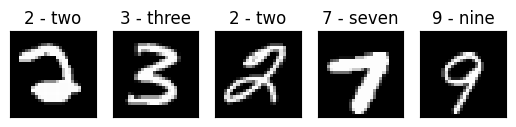

In [5]:
fig, ax  = plt.subplots(1,5)

for i in range(5):
    np.random.seed(i)
    rand_ints = (np.random.randint(1,len(train_data)))
    X, y = train_data[rand_ints]
    ax[i].imshow(X.squeeze(), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(class_dict[y])
    



In [6]:
from torch.utils.data import DataLoader

train_load = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_load = DataLoader(dataset=test_data, batch_size=32, shuffle=True)
train_load, test_load

(<torch.utils.data.dataloader.DataLoader at 0x147d50690>,
 <torch.utils.data.dataloader.DataLoader at 0x1479d7890>)

In [7]:
from torch import nn 

class CNN_MNST(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, out_shape:int) -> None:
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*49, out_features=out_shape)
        )
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        out1 = self.block1(x)
        out2 = self.block2(out1)
        return self.output(out2)
    

In [14]:
# define optim  and loss 
model_0 = CNN_MNST(input_shape=1, hidden_units=10, out_shape=len(class_dict))
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model_0.parameters(), lr=.01)

In [18]:
# build training loop
import torch.utils
import torch.utils.data


def run_train(model:nn.Module, 
              data_loader:torch.utils.data.DataLoader, 
              optim: torch.optim, 
              loss_fn:torch.nn):
    """Run training loop

    Args:
        model (nn.Module): _description_
        data_loader (torch.utils.data.DataLoader): _description_
        optim (torch.optim): _description_
        loss_fn (torch.nn): _description_
    """
    model.eval()
    tot_loss = 0 
    for batch, (X,y) in enumerate(data_loader):
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        tot_loss += loss
        
    tot_loss/=len(data_loader)
    
    return tot_loss


In [23]:
from torchmetrics.classification import MulticlassAccuracy

ac_fn = MulticlassAccuracy(num_classes=10)

def run_test(model:nn.Module, 
            data_loader:torch.utils.data.DataLoader, 
            ac_fn: None,
            loss_fn:torch.nn):
    
    tot_loss, tot_acc = 0,0
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            y_pred_test = model(X)
            tot_loss += loss_fn(y_pred_test, y)
            tot_acc += ac_fn(y_pred_test, y)
            
        tot_loss /= len(data_loader)
        tot_acc /= len(data_loader)
    return {'test loss': tot_loss.item(), 'test acc': tot_acc.item()}

In [24]:
from tqdm.auto import tqdm

for i in tqdm(range(3)):
    loss = run_train(model=model_0, data_loader=train_load, optim=optim, loss_fn=loss_fn)
    met_dict = run_test(model=model_0, data_loader=train_load, ac_fn=ac_fn, loss_fn=loss_fn)
    test_loss, test_acc = met_dict['test loss'], met_dict['test acc']
    print(f'loss {loss} | test loss {test_loss} | test_acc {test_acc}')

  0%|          | 0/3 [00:00<?, ?it/s]

loss 0.08592511713504791 | test loss 0.06952645629644394 | test_acc 0.9752722382545471
loss 0.08438040316104889 | test loss 0.07901178300380707 | test_acc 0.9710610508918762
loss 0.07987108826637268 | test loss 0.09697795659303665 | test_acc 0.9677037596702576


In [89]:
def make_pred(model:nn.Module, data:None):
    model.eval()
    with torch.inference_mode():
        preds=[]
        for i in (data):
        
            logits = model(i.unsqueeze(dim=0)).squeeze()
            probs = torch.softmax(logits, dim=0)
            preds.append(torch.argmax(probs).item())
        return preds

In [85]:
from random import sample, seed

seed(42)
test_samples = []
test_labels = []

for sample, label in sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(test_samples[0].shape)

torch.Size([1, 28, 28])


In [91]:
preds = make_pred(model_0, data=test_samples)
preds, test_labels

([2, 1, 2, 4, 6, 6, 4, 9, 1], [2, 1, 2, 4, 6, 6, 4, 9, 1])

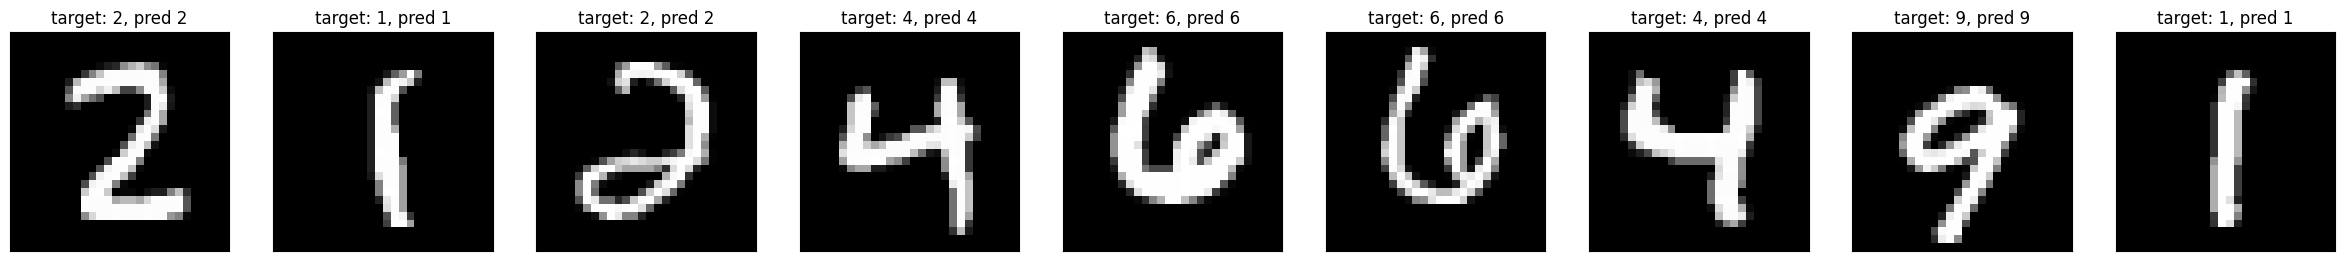

In [97]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,9)
fig.set_figwidth(30)
for num, i in enumerate(test_labels):
    ax[num].imshow(test_samples[num].squeeze(), cmap='gray')
    ax[num].set_title(f'target: {i}, pred {preds[num]}')
    ax[num].set_yticks([])
    ax[num].set_xticks([])

    

In [99]:
from torchmetrics import ConfusionMatrix

CM = ConfusionMatrix(num_classes=10, task='multiclass')

In [107]:
def grab_prebs(model:nn.Module, 
            data_loader:torch.utils.data.DataLoader, 
            ):
    preds = []
    tar_preds =[]
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            logits = model(X)
            probs = torch.softmax(logits, dim=1)
            preds.append(torch.argmax(probs, dim=1))
            tar_preds.append(y)
    return torch.cat(preds), torch.cat(tar_preds)

In [116]:
full_preds, tar_preds = grab_prebs(model=model_0, data_loader=test_load)
print(full_preds, tar_preds)
confus = CM(full_preds, tar_preds)


tensor([1, 3, 4,  ..., 6, 2, 6]) tensor([1, 3, 4,  ..., 6, 2, 6])


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

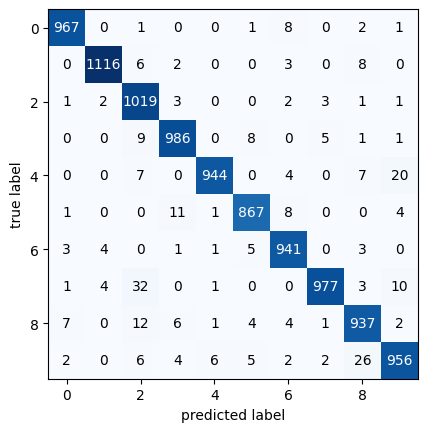

In [118]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(confus.numpy())
